In [1]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import psycopg2
from sqlalchemy import create_engine
import os
import plotly.figure_factory as ff
import plotly.express as px
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')

In [2]:
engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'.format(
    user = 'postgres',
    password = POSTGRES_PASSWORD,
    host = 'postgres',
    port = 5432,
    db = 'congress'
))

In [3]:
myquery = '''
SELECT directordername, bioguideid
FROM members
ORDER BY lastname
'''

members = pd.read_sql_query(myquery, engine)
memberlist = [{'label': x, 'value': y} for x, y in zip(members['directordername'], members['bioguideid'])]

In [4]:
#ideology not added... need to update but had issues with new data
myquery = '''
SELECT bioguideid,
directordername,
        party,
        state,
        district
FROM members m
'''

ideo_df = pd.read_sql_query(myquery, engine)
ideo_df['chamber'] = ideo_df['district'].isnull()
ideo_df['chamber'] = ideo_df['chamber'].replace({True:'Senate', False: 'House of Representatives'})

In [5]:
ideo_df['namedistrict'] = [n + ' (' + s + ')' if c =='Senate' else n + ' (' + s + ' - ' + str(int(d)) + ')' for n, s, c, d in zip(ideo_df['directordername'], ideo_df['state'], ideo_df['chamber'], ideo_df['district'])]

ideo_df['party'] = ideo_df['party'].replace({'D': 'Democrat',
                                             'I': 'Independent',
                                             'R': 'Republican'})

In [6]:
userbioguideid = 'G000595'
ideo2 = ideo_df.query(f"bioguideid == '{userbioguideid}'")

In [7]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [8]:
mymarkdown = '''

Congressional elections are usually all about the big national issues, but these Representatives and Senators work for local districts and states. Not all issues are the same everywhere. The purpose of this dashboard is to collect public data from these sources:

* [Official API for the U.S. Congress](https://api.congress.gov/)
* [Voteview](https://voteview.com/)
* [Open Secrets](https://opensecrets.org/open-data/api)
* [ProPublica's Data on Bills](https://www.propublica.org/)

'''

In [31]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

 

app.layout = html.Div(
    [
        # Stuff on top
        html.H1("Know Your Representatives in Congress"),
        html.H2("Data collected from APIs from Congress.gov, Open Secrets, Voteview.com, and ProPublica"),
        html.H3("DS 6600: Data Engineering 1, UVA Data Science"),
        
        # Side bar
        html.Div([
            dcc.Markdown('Please select a Representative or Senator:'),
            dcc.Dropdown(id = 'member', options = memberlist, value = 'A000370'),
            dcc.Markdown(mymarkdown),
        ], style = {'width': '24%', 'float':'left'}), 
        
        # Main bar
        html.Div([
            dcc.Tabs([
                dcc.Tab(label = 'Biographical Info', children = [
                    # stuff for bio tab goes here
                    html.Div([html.Img(id = 'bioimage', style={'height':'100%', 'width':'100%'})], style = {'width': '24%', 'float':'left'}),
                    html.Div([dcc.Graph(id = 'biotable')], style = {'width': '74%', 'float':'right'})
                ]),

 

                dcc.Tab(label = 'Bill Sponsorship', children = [
                    dcc.Graph(id = 'money')
                ]),

 

                dcc.Tab(label = 'Voting and Ideology', children = [
                    dcc.Graph(id = 'ideograph', style={'height':'100%', 'width':'100%'}),
                    dcc.Markdown("Heare are the top 10 most similar members of Congress by voting record: "),
                    dcc.Graph(id = 'votesim')
                ]),

 

                dcc.Tab(label = 'Donors and Financial Info', children = [
                    # stuff for donors tab goes here
                ])
                
            ])
        ], style = {'width': '74%', 'float':'right'})
    ]
)

 

@app.callback([Output(component_id = 'biotable', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

 

def biotable(b):
    myquery = f'''
    SELECT directordername AS Name,
        party AS Party,
        state AS State,
        CAST(district AS int) AS District,
        birthyear AS Birthyear,
        addressinformation_officeaddress AS Address,
        CONCAT(addressinformation_city, ', ' , addressinformation_district) AS City,
        addressinformation_zipcode AS Zipcode,
        addressinformation_phonenumber AS Phone
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    mydf.columns = [x.capitalize() for x in mydf.columns]
    mydf = mydf.T.reset_index()
    mydf = mydf.rename({'index':'', 0:''}, axis=1)
    return [ff.create_table(mydf)]

 

@app.callback([Output(component_id = 'bioimage', component_property = 'src')],
             [Input(component_id = 'member', component_property = 'value')])

 

def bioimage(b):
    myquery = f'''
    SELECT depiction_imageurl
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    return [mydf['depiction_imageurl'][0]]

 

@app.callback([Output(component_id = 'ideograph', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

 

def ideograph(b):
    ideo2 = ideo_df.query(f"bioguideid == '{b}'")
    fig = px.scatter(ideo_df, x='ideology', y='chamber', color='party',
                     color_discrete_map={'Republican': 'red',
                                         'Democrat': 'blue',
                                         'Independent': 'green'},
                     #height=300, width=600,
                     labels={'ideology':'Left/Right Ideology (DW-NOMINATE)', 
                            'chamber':'Chamber',
                            'party': 'Political Party'},
                     hover_name = 'namedistrict',
                     hover_data=['party'],
                     title = 'Ideological Placements in Congress',
                    opacity = .1)
    
    fig.update(layout=dict(title=dict(x=0.5)))
    fig.update_yaxes(range=(-0.5, 1.5), tickvals=[0, 1],
                    ticktext = ['Senate', 'House of Representatives'])
    fig.update_xaxes(range=(-1,1), tickvals=[-1, -.5, 0, .5, 1],
                    ticktext = ['Extreme left', 'Moderate left', 'Centrist', 'Moderate right', 'Extreme right'])
    
    fig.add_traces(
        px.scatter(ideo2, x='ideology', y='chamber', color='party',
                     color_discrete_map={'Republican': 'red',
                                         'Democrat': 'blue',
                                         'Independent': 'green'},
                     height=300, width=600,
                     labels={'ideology':'Left/Right Ideology (DW-NOMINATE)', 
                            'chamber':'Chamber',
                            'party': 'Political Party'},
                     hover_name = 'namedistrict',
                     hover_data=['party'],
                     title = 'Ideological Placements in Congress').update_traces(marker=dict(size=8, symbol="star", line=dict(width=2, color="DarkSlateGrey")),
                                                                                 showlegend=False).data
    )

 

    fig.update_layout(autosize=True)
    
    
    return [fig]

@app.callback([Output(component_id = 'votesim', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

def votesim(b):

    myquery = f'''
    SELECT m.directordername,
        m.state,
        m.party,
        g.affinity_score
    FROM members m
    INNER JOIN (SELECT v.member_compare, v.affinity_score
            FROM members m
            INNER JOIN votesim v
                ON m.icpsr = v.icpsr
            WHERE m.bioguideid = '{b}'
            ORDER BY v.affinity_score DESC
            LIMIT 10) g
        ON m.icpsr = g.member_compare   
    ORDER BY g.affinity_score DESC
    '''
    votedf = pd.read_sql_query(myquery, con=engine)
    votedf = votedf.rename({'directordername': 'Name', 
                           'state': 'State',
                           'party': 'Party',
                           'affinity_score': 'Vote Similarity'}, axis =1)
    votedf['Vote Similarity'] = round(100*votedf['Vote Similarity'], 1).astype('str') + '%'
    return [ff.create_table(votedf)]

@app.callback([Output(component_id = 'money', component_property = 'figure')],
             [Input(component_id = 'member', component_property = 'value')])

def contribgraph(b):
    myquery = f'''
    SELECT m.directordername,
        c.org_name,
        c.total,
        c.pac,
        c.ndiv
    FROM contributions c
    INNER JOIN members m
        ON m.cid = c.cid
    WHERE m.bioguideid = '{b}'
    '''
    contribdf = pd.read_sql_query(myquery, con=engine)
    name = contribdf['directordername'][0]
    contribdf = contribdf.drop(['directordername'], axis=1)
    contribdf = contribdf.rename({'org_name': 'Organization',
                                 'pac': 'Contribution Via PAC',
                                 'ndiv': 'Direct Contribution'}, axis =1)
    contribdf = pd.melt(contribdf, id_vars = ['Organization'],
                       value_vars = ['Contribution Via PAC', 'Direct Contribution'])
    fig = px.bar(contribdf, x='value', y = 'Organization', color='variable', labels = {'value': 'Amount Donated',
                                                                                      'variable': 'Source'},
                title = f"Who's giving money to {name}?")
    fig.update(layout=dict(title=dict(x=0.5)))
    return [fig]


if __name__== "__main__":
    app.run(mode= 'external', host = "0.0.0.0", port = 8050, debug=True)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File /usr/local/lib/python3.11/site-packages/pandas/core/indexes/range.py:345, in RangeIndex.get_loc(
    self=RangeIndex(start=0, stop=0, step=1),
    key=0
)
    344 try:
--> 345     return self._range.index(new_key)
        new_key = 0
        self = RangeIndex(start=0, stop=0, step=1)
        self._range = range(0, 0)
    346 except ValueError as err:

ValueError: 0 is not in range

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
KeyError: 0

---------------------------------------------------------------------------
UndefinedTable                            Traceback (most recent call last)
File /usr/local/lib/python3.11/site-packages/sqlalchemy/engine/base.py:1969, in Connection._exec_single_context(
    self=<sqlalchemy.engine.base.C

In [ ]:
b = 'A000370'
def biotable(b):
    myquery = f'''
    SELECT directordername AS Name,
        party AS Party,
        state AS State,
        CAST(district AS int) AS District,
        birthyear AS Birthyear,
        addressinformation_officeaddress AS Address,
        CONCAT(addressinformation_city, ', ', addressinformation_district) AS City,
        addressinformation_phonenumber AS Phone,
        addressinformation_zipcode AS Zipcode
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    mydf.columns = [x.capitalize() for x in mydf.columns]
    mydf = mydf.T.reset_index()
    mydf = mydf.rename({'index':'', 0:''}, axis=1)
    #print("here")
    return ff.create_table(mydf)

In [ ]:
biotable(b)    

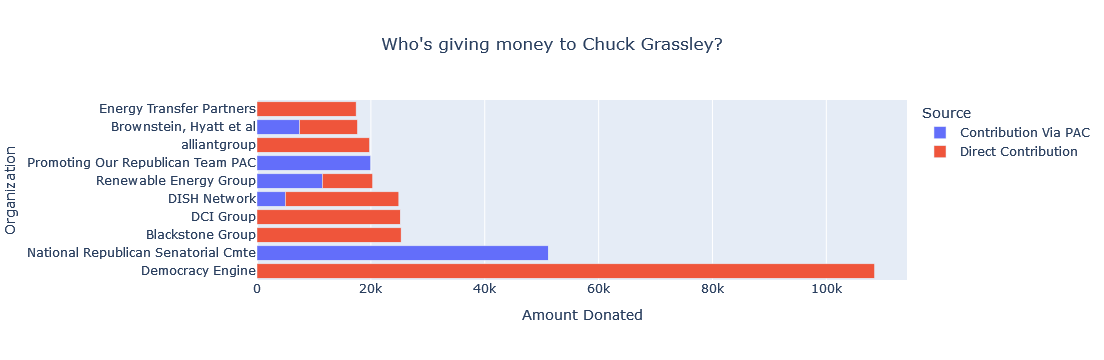

In [30]:
b = 'G000386'
myquery = f'''
SELECT m.directordername,
    c.org_name,
    c.total,
    c.pac,
    c.ndiv
FROM contributions c
INNER JOIN members m
    ON m.cid = c.cid
WHERE m.bioguideid = '{b}'
'''
contribdf = pd.read_sql_query(myquery, con=engine)
name = contribdf['directordername'][0]
contribdf = contribdf.drop(['directordername'], axis=1)
contribdf = contribdf.rename({'org_name': 'Organization',
                             'pac': 'Contribution Via PAC',
                             'ndiv': 'Direct Contribution'}, axis =1)
contribdf = pd.melt(contribdf, id_vars = ['Organization'],
                   value_vars = ['Contribution Via PAC', 'Direct Contribution'])
fig = px.bar(contribdf, x='value', y = 'Organization', color='variable', labels = {'value': 'Amount Donated',
                                                                                  'variable': 'Source'},
            title = f"Who's giving money to {name}?")
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

In [ ]:
b = 'G000386'
myquery = f'''
SELECT v.member_compare, v.affinity_score
FROM members m
INNER JOIN votesim v
    ON m.icpsr = v.icpsr
WHERE m.bioguideid = '{b}'
ORDER BY v.affinity_score DESC
LIMIT 10
'''
pd.read_sql_query(myquery, con=engine)

In [ ]:
myquery = f'''
SELECT m.directordername,
    m.state,
    m.party,
    g.affinity_score
FROM members m
INNER JOIN (SELECT v.member_compare, v.affinity_score
        FROM members m
        INNER JOIN votesim v
            ON m.icpsr = v.icpsr
        WHERE m.bioguideid = '{b}'
        ORDER BY v.affinity_score DESC
        LIMIT 10) g
    ON m.icpsr = g.member_compare   
ORDER BY g.affinity_score DESC
'''
votedf = pd.read_sql_query(myquery, con=engine)
votedf = votedf.rename({'directordername': 'Name', 
                       'state': 'State',
                       'party': 'Party',
                       'affinity_score': 'Vote Similarity'}, axis =1)
votedf['Vote Similarity'] = round(100*votedf['Vote Similarity'], 1).astype('str') + '%'
ff.create_table(votedf)